In [4]:
### 🛑 Import des bibliothèques
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import fft
import time

# Retour sur la transformée de Fourier discrète

Comme vous avez déjà eu l'occasion de vous en apercevoir lors des 2 précédents TPs, la maîtrise de la transformée de Fourier discrète (abrégée TFD) ne se fait pas sans peine :
- c'est déjà pas évident dans le monde continu, avec des signaux théoriques et idéaux définis sur $\mathbb{R}$
- mais la discrétisation des signaux et de leur transformée de Fourier pour passer dans le monde numérique en rajoute encore une couche...

Et pourtant, cette TFD est cruciale pour tout ce qui touche de près ou de loin à des signaux, notamment car il est possible de la calculer de manière **performante** grâce à l'algorithme de transformée de Fourier rapide (ou FFT pour *Fast Fourier Transform*).
De part son importance absolument **capitale**, notamment pour ses applications en compression de données et en communications numériques (où les besoins de stockage et de transmission de données volumineuses se font avec de fortes contraintes de temps et/ou bande passante), la FFT est d'ailleurs considérée comme un algorithme du [top 10 des algorithmes du 20e siècle](https://www.computer.org/csdl/magazine/cs/2000/01/c1022/13rRUxBJhBm) par le journal *Computing in Science & Engineering*

Mais avant de découvrir pourquoi, et surtout comment la FFT fonctionne, il convient de revenir (un peu) en arrière...

## Du monde continu au monde discret

On commence par rappeler quelques notions sur le passage du monde continu au monde discret pour la transformée de Fourier, qui ont déjà été abordées lors du TP de prise en main de la transformée de Fourier discrète.

Pour un signal $x : t \mapsto x(t)$ continu, la transformée de Fourier $X = \mathcal{F}(x)$ est également continue :

$$\begin{align}
X :\mathbb{R} &\rightarrow \mathbb{C}\\
\nu &\mapsto X(\nu) = \displaystyle \int_{\mathbb{R}} x(t) e^{-i 2 \pi \nu t} dt \quad (1)
\end{align}$$

Un signal $x$ discret se représente en revanche comme un vecteur de $N$ points : $x = \big[x[0],\dots,x[N-1]\big]$. C'est le cas de n'importe quel signal manipulé sur un ordinateur (ou autre support à mémoire finie). 
Il en va évidemment de même pour sa transformée de Fourier, qui est également finie et discrète.

Par défaut, la TFD $X$ d'un signal $x$ de longueur $N$ se calcule également sur $N$ points (bien qu'il soit aussi possible de la calculer sur $M > N$ points, comme nous l'avons vu lors du TP sur la prise en main de la TFD avec la stratégie de sur-échantillonnage de la TFD).<br>
Ainsi, $X$ est également un vecteur de longueur $N$ : $X = \big[X[0],\dots,X[N-1]\big]$, dont chaque composante $X[k]$ s'obtient par la formule de la TFD :<br>

$$X[k] = \displaystyle \sum_{n=0}^{N-1} x[n] e^{-i 2 \pi \large\frac{nk}{N}} \quad k = 0,\dots,N-1 \quad (2)$$

On peut se convaincre sans trop de peine que $(2)$ est bien une version discrétisée de $(1)$ pour un signal de longueur $N$.

Dans l'équation (2) :

- $X[k]$ est le $k$-ième coefficient de la TFD, représentant la contribution de la fréquence $k$.
- $x[n]$ est la valeur du signal à l'instant $n$.
- $N$ est la longueur du signal (nombre total d'échantillons).
- $e^{-i 2\pi \large\frac{k n}{N}}$ est le terme complexe correspondant à l'oscillation sinusoïdale de fréquence $k$.

<br>
L'équation (2) peut se factoriser comme un produit matrice-vecteur de type $X = F \cdot x$, ou, de manière un peu plus explicite :

$$\begin{bmatrix}X[0] \\ \vdots \\ X[k] \\ \vdots \\X[N-1]\end{bmatrix}
= 
\begin{bmatrix}
\ddots & & \dots & & ⋰ \\
& \ddots & & ⋰ & \\
\vdots & & F_{kn} & & \vdots \\
& ⋰ & & \ddots & \\
⋰ & & \dots & & \ddots \\
\end{bmatrix}
\begin{bmatrix}x[0] \\ \vdots \\ x[n] \\ \vdots \\x[N-1]\end{bmatrix}
$$

Avec $F$ une matrice de taille $N \times N$ appelée **matrice de Fourier**, dont les éléments sont définis par :

$$
F_{kn} = e^{-i 2\pi \large\frac{k  n}{N}}, \quad \forall k, n = 0, \dots, N-1
$$

Avec cette notation, on peur réécrire (2) comme $$X[k] = \displaystyle \sum_{n=0}^{N-1} x[n] F_{kn} \quad \forall k = 0,\dots,N-1 \quad (2\text{bis})$$


### Lien avec les racines nièmes de l'unité

Le terme général $F_{kn}$ de la matrice $F$ peut se réécrire $\displaystyle F_{kn} = e^{-i 2\pi \large\frac{k  n}{N}} = \left( e^{-i \large\frac{2 \pi}{N}} \right)^{kn}$, et on reconnait en $e^{-i \large\frac{2 \pi}{N}}$ une racine $N$-ième de l'unité. Les entrées de la matrice de Fourier $F$ sont donc les différentes puissances des racines $N$-ième de l'unité !

Par exemple, si $N = 4$, alors $e^{-i\large\frac{2 \pi}{N}} = e^{-i \large\frac{2 \pi}{4}} = e^{-i \large\frac{\pi}{2}} = -i$, et la matrice $F$, de taille $4 \times 4$, s'écrit donc :

$$ F = 
\begin{bmatrix}
F_{00} & F_{01} & F_{02} & F_{03}\\
F_{10} & F_{11} & F_{12} & F_{13}\\
F_{20} & F_{21} & F_{22} & F_{23}\\
F_{30} & F_{31} & F_{32} & F_{33}
\end{bmatrix} 
=
\begin{bmatrix}
(-i)^0 & (-i)^0 & (-i)^0 & (-i)^0\\
(-i)^0 & (-i)^1 & (-i)^2 & (-i)^3\\
(-i)^0 & (-i)^2 & (-i)^4 & (-i)^6\\
(-i)^0 & (-i)^3 & (-i)^6 & (-i)^9
\end{bmatrix}
=
\begin{bmatrix}
1 &  1 &  1 &  1\\
1 & -i & -1 &  i\\
1 & -1 &  1 & -1\\
1 &  i & -1 & -i
\end{bmatrix} 
$$

On peut s'apercevoir dans cet exemple (et ça reste vrai dans le cas général, peu importe $N$) que la matrice de Fourier $F$ possède des symétries très fortes, et notamment le fait qu'elle est égale à sa transposée : $F^T = F$.

Ce sont justement ces symétries qui sont exploitées par l'algorithme FFT pour réduire la complexité de calcul, comme on le verra un peu plus tard.

### 🛠️ 🚧 👷  À vous de jouer !

Complétez la fonction suivante pour calculer la matrice de Fourier $F$ en fonction de $N$, et vérifiez que vous obtenez bien le bon résultat pour $N = 4$ (grâce à [`np.isclose`](https://numpy.org/doc/stable/reference/generated/numpy.isclose.html))

<u>Rappel :</u> le nombre imaginaire $i$ s'écrit `1j` en python. Pour la fonction exponentielle $e$, c'est (sans surprise) vers [`np.exp`](https://numpy.org/doc/stable/reference/generated/numpy.exp.html) qu'il faut vous tourner. Et pour la constant $\pi$, c'est `np.pi`.

In [5]:
# Définition de la matrice de Fourier de taille NxN
def Fourier_matrix(N):
    F = np.zeros((N,N)).astype('complex') # initialise F de type complexe
    for k in range(N):
        n = np.arange(N) # FIXME
        F[k, :] = np.exp(-2j * np.pi * k * n / N)
    return F

In [6]:
F4 = np.array([[1,  1, 1, 1],
               [1,-1j,-1, 1j],
               [1, -1, 1,-1],
               [1, 1j,-1,-1j]])

# comparaison de la matrice de Fourier avec F4 dans le cas où N=4
np.isclose(Fourier_matrix(4), F4) # FIXME

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

## Un premier algorithme naïf pour le calcul de la TFD

Un premier algorithme de calcul naïf de la TFD via l'équation $(2)$ ou $(2\text{bis})$ a donc une complexité de $\mathcal{O}(N^2)$ car le calcul de chaque coefficient $X[k]$ nécessite la somme de $N$ termes, et cela pour chaque $k = 0,\dots,N-1$.

Cette opération étant équivalente à la multiplication d'une matrice de taille $N \times N$ par un vecteur de longueur $N$, le fait que la complexité soit en $\mathcal{O}(N^2)$ ne devrait de toute façon pas être une grosse surprise.

Il est donc maintenant temps d'implémenter ce premier algorithme de calcul naïf de la TFD ! Pour cela, on va définir un signal de taille $N=8$ dont les entrées sont des entiers aléatoires dans $[0,10[$ (les valeurs du signal $x$ n'ont aucune importance ici).

In [7]:
# 🛑 Définition d'un signal de taille 8 et d'entrées aléatoires dans [0,10[
x = np.random.randint(10,size=8)
print("Le signal x =",x, "de taille N = %d"%x.size)

Le signal x = [2 0 5 7 3 8 1 8] de taille N = 8


### 🛠️ 🚧 👷  À vous de jouer !

Complétez la fonction suivante pour calculer la transformée de Fourier discrète naïve d'un signal $x$ donné, en implémentant l'équation $(2\text{bis})$, et vérifiez que vous obtenez bien le même résultat que `sp.fft.fft` sur le signal $x$ (encore une fois, grâce à [`np.isclose`](https://numpy.org/doc/stable/reference/generated/numpy.isclose.html))

In [8]:
# Implémentation naïve de la TFD
def DFT_naive(x):
    X = np.zeros(x.size).astype('complex') # initialise X de même taille que x et de type complexe
    F = Fourier_matrix(x.size) # FIXME
    for k in range(X.size):
        for n in range(x.size):
            X[k] += F[k,n]*x[n] # FIXME
    return X

In [9]:
# comparaison de l'implémentation naïve avec sp.fft.fft
np.isclose(DFT_naive(x), sp.fft.fft(x)) # FIXME

array([ True,  True,  True,  True,  True,  True,  True,  True])

## Vérification de la complexité en $\mathcal{O}(N^2)$ pour l'implémentation naïve

On va maintenant vérifier que cette implémentation naïve pour la TFD est bien en $\mathcal{O}(N^2)$. Pour cela, on va monitorer le temps d'exécution grâce à `time` (que vous avez déja rencontré pour l'exercice sur le théorème de Plancherel lors du TP sur les applications de la transformée de Fourier), dont le fonctionnement vous est rappelé ci-dessous.

Il suffira alors de mesure le temps d'exécution de la TFD pour des tailles $N$ croissantes

In [10]:
# 🛑 Monitorer le temps d'exécution d'une fonction / partie de code
t_begin = time.time() # lancement du ⏱️
for ii in range(10): # répétition 10x
    time.sleep(0.2) # pause de 0.2 secondes
t_end = time.time() # fin du ⏱️
t_elapse = t_end - t_begin # temps écoulé
print("Temps écoulé : ",t_elapse)

Temps écoulé :  2.0028510093688965


Puisqu'on s'attend à ce que ça tourne en $\mathcal{O}(N^2)$, on va limiter un peu l'étendue de la plage des tailles $N$, en l'occurence entre $N=2^4$ et $N = 2^{12}$

In [11]:
# 🛑 liste des tailles N (de la forme 2^p)
list_N = 2**np.arange(4,13)
print("Liste des tailles N pour la TFD :",list_N)

Liste des tailles N pour la TFD : [  16   32   64  128  256  512 1024 2048 4096]


### 🛠️ 🚧 👷  À vous de jouer !

Complétez la cellule suivante pour calculer, pour chaque longueur $N$ dans `list_N`, le temps de calcul de la TFD d'un signal aléatoire de longueur $N$. Tracez ensuite le temps de calcul en fonction de $N$. <br>
L'algorithme naïf de calcul de la TFD est-il bien en $\mathcal{O}(N^2)$ ?

⚠️ La cellule suivante doit mettre entre 30 secondes et 1 minute pour s'exécuter (si vous avez fait les choses correctement).

In [12]:
t_elapse = []
for N in list_N:
    x = np.random.randint(10,size=N) # FIXME
    t_begin = time.time() # FIXME
    X = DFT_naive(x) # FIXME
    t_end = time.time() # FIXME
    t_elapse.append((t_end-t_begin))

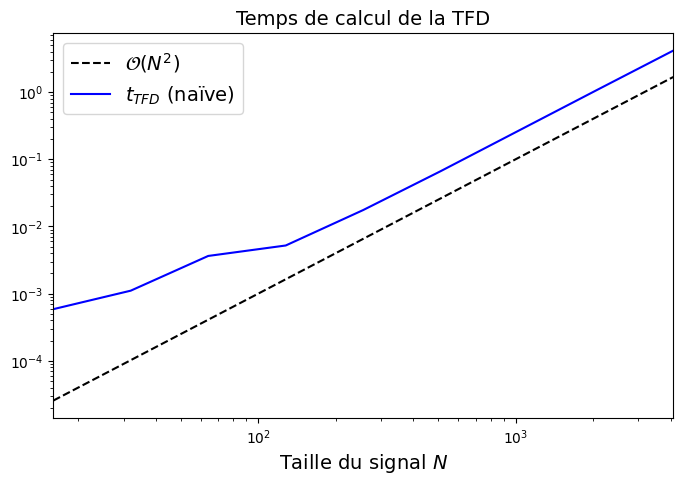

In [13]:
# 🛑 Temps de calcul de la TFD naïve vs O(N^2)
plt.figure(figsize=(8,5))
idx_norm = np.round(np.log10(list_N[-1]**2))
plt.loglog(list_N,list_N**2/(10**idx_norm),'k--',label=r'$\mathcal{O}(N^2)$')
plt.loglog(list_N,t_elapse,'b',label=r'$t_{TFD}$ (naïve)')
plt.xlim(list_N.min(),list_N.max())
plt.xlabel(r'Taille du signal $N$',fontsize=14)
plt.title(r'Temps de calcul de la TFD',fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.show()

On peut donc en conclure que $\mathcal{O}(N^2)$

# Bravo !

Vous en avez fini avec l'implémentation naïve de la TFD. Il est maintenant temps de se tourner vers [l'algorithme FFT](TP4_AlgorithmeFFT_exo2.ipynb), nettement plus costaud (mais tellement plus beau 🤩)